In [38]:
import numpy as np
import scipy.integrate as sp
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [39]:
V_0 = 5
x0=1
a = 2
a1=10
a2=1
b=1
def V1(x):
        return -V_0/2*(1-np.sign(np.abs(x)-a))
def V2(x):
        return V_0*(x/a)**2
def V3(x):
        return 4*V_0*((a1*2**(-1/6)/x)**12-(a1*2**(-1/6)/x)**6 )
def V4(x):
        return V_0*((1-np.exp(-a*(x-x0)))**2)
def V5 (x):
    #quadratic well
    return V_0/2*((x/b)**2-1)*(1-np.sign(np.abs(x)-b))
def V6(x):
    return 100*(V_0-V_0/2*(1-np.sign(np.abs(x)-a)))
def normalization(psi, x):
    norm = sp.simps(abs(psi)**2,x)
    return psi/np.sqrt(norm)

In [40]:
def numerov(psi_range,x_range,V,E,direction):
    """psi_range = array contenant les psi_i avec les valeurs aux bords déjà mises en place 
    x_range = array contenant les x
    V = fonction jouant le role de potentiel
    E = energie à tester
    direction -> 1 = gauche/droite  -1=droite/gauche"""
    
    #création de variables utiles
    Q = lambda x : 2*(E-V(x))
    h = x_range[1]-x_range[0]  
    psi_out = psi_range.copy()
    
    #réalisation de l'intégration de Numerov
    if direction == 1 :
        for i in range(2,len(psi_range)):
            psi_out[i] = (2*(1-5/12*h**2*Q(x_range[i-1]))*psi_out[i-1]-(1+1/12*h**2*Q(x_range[i-2]))*psi_out[i-2])/(1+1/12*h**2*Q(x_range[i]))
    if direction == -1 :
        for i in range(len(psi_range)-3,-1,-1):
            psi_out[i] = (2*(1-5/12*h**2*Q(x_range[i+1]))*psi_out[i+1]-(1+1/12*h**2*Q(x_range[i+2]))*psi_out[i+2])/(1+1/12*h**2*Q(x_range[i]))
    
    return psi_out

In [41]:
def calculus(x_range,E,V):
    """
    CALCULE LA FONCTION D'ONDE AVEC LA METHODE MIDPOINT POUR UNE ENERGIE ET UN POTENTIEL DONNES
    """
    N_x_c=int(len(x_range)/2)
    psi_range=np.zeros(len(x_range))
    psi_range[0] = 0
    psi_range[1] = eps
    psi_range[-1] = 0
    psi_range[-2] = eps
    #découpage des ranges au mid-point
    x_left = x_range.copy()[0:N_x_c+1]
    x_right = x_range.copy()[N_x_c:] 
    
    psi_left = psi_range.copy()[0:N_x_c+1]
    psi_right = psi_range.copy()[N_x_c:]
    
    #réalisation des intégrations de numerov
    psi_left = numerov(psi_left,x_left,V,E,1)
    psi_right = numerov(psi_right,x_right,V,E,-1)
    psi_out = np.concatenate((psi_left[0:-1],psi_right*((psi_left[-1])/(psi_right[0]))))

    return psi_out

In [42]:
def recherche_lin(V,x_range,E_min,E_max,dE,eps,sens):
    """
    CONTIENT LES BORNES ET LE PAS DES ENERGIES A TESTER. TRACE LA DIVERGENCE DE LA FONCTION D'ONDE EN x_M EN FONCTION DE L'ENERGIE. SORT LES MINIMAS LOCAUX DU ln DE CETTE DIVERGENCE.
    CALCULE LA FONCTION D'ONDE DE GAUCHE A DROITE OU DE DROITE A GAUGHE SELON LE SIGNE DE "sens"
    V=potentiel
    E_min,E_max = bornes d'energies à tester
    dE= pas entre 2 energies testées 
    eps= valeurs de la dérivée première de psi au premier point (la valeur de psi est arbitrairement prise à 0)
    sens= +1(-1) pour calculer les fonctions d'ondes de selon les x croissant(décroissant)
    """
    N_E=int((E_max-E_min)/dE+1)
    E_range=np.linspace(E_min,E_max,N_E)
    I=[]
    Y_last=[]
    Z_last=[]
    print("RECHERCHE LINEAIRE:")
    for E in tqdm(E_range):
        psi_range = np.zeros(len(x_range))
        if sens==1:
            psi_range[0] = 0
            psi_range[1] = eps
            out=numerov(psi_range,x_range,V,E,1)
            Y_last.append(abs(out[-1]))
            Z_last.append(np.log(abs(out[-1])))

        if sens ==-1:   
            psi_range[-1] = 0
            psi_range[-2] = eps
            out=numerov(psi_range,x_range,V,E,-1)
            Y_last+=[abs(out[0])]
            Z_last+=[np.log(abs(out[0]))]
            
    #plt.plot(E_range,np.abs(Y_last))
    #plt.plot(E_range,Z_last)
    E_value=[]
    for i in range (1,N_E-1):
        if Z_last[i]<Z_last[i+1] and Z_last[i]<Z_last[i-1]:
            E_value.append(E_range[i])
    return E_value

In [43]:
def dichotomie (V,x_range,Nb_passage,It_passage,zoom,E_ini,delta_E,eps,sens):
    """
    V=potentiel
    Nb_passage=nombre de passage effectuées
    It_passage=nombre d'iterations effectuées à chaque passage (doit être > 4)
    zoom=valeur de l'augmentation de precision entre chaque passage
    E_ini=valeur de depart de recherche de l'energie
    delta_E= étendue de recherche de l'énergie autour de E_ini
    eps= valeurs de la dérivée première de psi au premier point (la valeur de psi est arbitrairement prise à 0)
    sens= +1(-1) pour calculer les fonctions d'ondes de selon les x croissant(décroissant)
    """
    psi_zero=np.zeros(len(x_range))
    for passage in range(0,Nb_passage): 
        # boucle de recherche de l'energie optimale par passage dans la gamme d'energie donnée par E_range:
        E_range=np.linspace(E_ini-delta_E/2,E_ini+delta_E/2,It_passage) #créé la liste des valeurs de E à être testés
        Z_last=[] # contient la dernière valeur de chaque fonction d'onde (en log)

        for iteration in range (0,It_passage):
            # boucle de calcul de la fonction d'onde correspondant chaque energie dans E_range:
            E=E_range[iteration]
            #remise à 0 de la fonction d'onde:
            psi_range = psi_zero
            psi_range[0] = 0
            psi_range[1] = eps
            out=numerov(psi_range,x_range,V,E,sens)
            Z_last.append(np.log(abs(out[-1])))
            
        # selection de l'energie optimale:
        E_ini=E_range[np.argmin(Z_last)]
        delta_E/=zoom
    return E_ini
            


In [44]:
def dichotomie_sens (V,x_range,Nb_passage,It_passage,zoom,E_ini,delta_E,eps,sens):
    """
    V=potentiel
    Nb_passage=nombre de passage effectuées
    It_passage=nombre d'iterations effectuées à chaque passage (doit être > 4)
    zoom=valeur de l'augmentation de precision entre chaque passage
    E_ini=valeur de depart de recherche de l'energie
    delta_E= étendue de recherche de l'énergie autour de E_ini
    eps= valeurs de la dérivée première de psi au premier point (la valeur de psi est arbitrairement prise à 0)
    sens= +1(-1) pour calculer les fonctions d'ondes de selon les x croissant(décroissant)
    """
    psi_zero=np.zeros(len(x_range))
    for passage in tqdm(range(0,Nb_passage)): 
        # boucle de recherche de l'energie optimale par passage dans la gamme d'energie donnée par E_range:
        E_range=np.linspace(E_ini-delta_E/2,E_ini+delta_E/2,It_passage) #créé la liste des valeurs de E à être testés
        Z_last=[] # contient la dernière valeur de chaque fonction d'onde (en log)

        for iteration in range (0,It_passage):
            # boucle de calcul de la fonction d'onde correspondant chaque energie dans E_range:
            E=E_range[iteration]
            psi_range = psi_zero
            if sens==1:
                psi_range[0] = 0
                psi_range[1] = eps
                out=numerov(psi_range,x_range,V,E,1)
                Z_last.append(np.log(abs(out[-1])))

            if sens ==-1:   
                psi_range[-1] = 0
                psi_range[-2] = eps
                out=numerov(psi_range,x_range,V,E,-1)
                Z_last+=[np.log(abs(out[0]))]

            
        # selection de l'energie optimale:
        E_ini=E_range[np.argmin(Z_last)]
        delta_E/=zoom
    return E_ini
            


In [45]:
def dichotomie_affiche (V,x_range,Nb_passage,It_passage,zoom,E_ini,delta_E,eps,sens):
    """
    V=potentiel
    Nb_passage=nombre de passage effectuées
    It_passage=nombre d'iterations effectuées à chaque passage (doit être > 4)
    zoom=valeur de l'augmentation de precision entre chaque passage
    E_ini=valeur de depart de recherche de l'energie
    delta_E= étendue de recherche de l'énergie autour de E_ini
    eps= valeurs de la dérivée première de psi au premier point (la valeur de psi est arbitrairement prise à 0)
    sens= +1(-1) pour calculer les fonctions d'ondes de selon les x croissant(décroissant)
    """
    affiche_sol=input("Afficher les solutions intermédiaires ? (y/n)")
    affiche_graph=input("Afficher les graphiques intermédiaires ? (y/n)")
    psi_zero=np.zeros(len(x_range))
    if affiche_graph=="y":
        plt.figure(figsize=(30, 10))
    for passage in range(0,Nb_passage): 
        # boucle de recherche de l'energie optimale par passage dans la gamme d'energie donnée par E_range:
        E_range=np.linspace(E_ini-delta_E/2,E_ini+delta_E/2,It_passage) #créé la liste des valeurs de E à être testés
        Z_last=[] # contient la dernière valeur de chaque fonction d'onde (en log)

        for iteration in range (0,It_passage):
            # boucle de calcul de la fonction d'onde correspondant chaque energie dans E_range:
            E=E_range[iteration]
            psi_range = psi_zero
            if sens==1:
                psi_range[0] = 0
                psi_range[1] = eps
                out=numerov(psi_range,x_range,V,E,1)
                Z_last.append(np.log(abs(out[-1])))

            if sens ==-1:   
                psi_range[-1] = 0
                psi_range[-2] = eps
                out=numerov(psi_range,x_range,V,E,-1)
                Z_last+=[np.log(abs(out[0]))]

            
        # selection de l'energie optimale:
        E_ini=E_range[np.argmin(Z_last)]
        delta_E/=zoom
        if affiche_sol=="y":
            print("Passage",passage+1,": ",E_ini," Precision: ",delta_E)
        if affiche_graph=="y":
            place=10-Nb_passage+passage
            if place>0:
               #remise à 0 de la fonction d'onde:
                psi_range = psi_zero
                psi_range[0] = 0
                psi_range[1] = eps
                out=calculus(x_range,E_ini,V)
                string=str(2)+str(5)+str(place)
                plt.subplot(int(string))
                plt.plot(x_range,out)
                plt.title("precision: "+str(delta_E))
    return E_ini
            


In [46]:
def recherche(V,E_min,E_max,dE,sens,x_range,Nb_passage,It_passage,zoom,delta_E,eps):
    """
    V=potentiel
    E_min=plus petite valeur de l'energie à être testée
    E_max=plus grande valeur de l'energie à être testée
    dE=pas des energies à tester lors de la recherche linéaire
    sens= +1(-1) pour calculer les fonctions d'ondes de selon les x croissant(décroissant)    
    x_range= valeurs des x pour lesquels psi va être calculée
    Nb_passage=nombre de passage effectuées
    It_passage=nombre d'iterations effectuées à chaque passage (doit être > 4)
    zoom=valeur de l'augmentation de precision entre chaque passage
    delta_E= étendue de recherche de l'énergie autour de E_ini
    """
    E_lin_list=recherche_lin(V,x_range,E_min,E_max,dE,eps,sens) #recherche approximative des énergies
    E_dich_list=[]
    psi_zero=np.zeros(len(x_range))
    print("\n \n AUGMENTATION DE LA PRECISION DES ENERGIES:")
    for i in tqdm(range(0,len(E_lin_list))): #augmentation de la précision des énergies
        E_ini=E_lin_list[i] #valeur de depart de recherche de l'energie
        delta_E=0.1 #étendue de recherche de l'énergie autour de E_ini
        x_range = np.linspace(x_m,x_M,int((x_M-x_m)/dx))
        print(" \n RECHERCHE PAR DICHOTOMIE DE L'ENERGIE "+str(i+1)+":")
        E_dich_list.append(dichotomie_sens(V,x_range,Nb_passage,It_passage,zoom,E_ini,delta_E,eps,sens))
        print(str(E_lin_list[i]) +" ===> "+ str(E_dich_list[i])+"\n \n")
    for i in range (0,len(E_dich_list)): #tracé des fonctions d'onde
        #remise à 0 de la fonction d'onde:
        psi_range = psi_zero
        psi_range[0] = 0
        psi_range[1] = eps
        out=calculus(x_range,E_dich_list[i],V)
        plt.plot(x_range,normalization(out,x_range))
    
    #return E_dich_list

(0.0, 100.0)

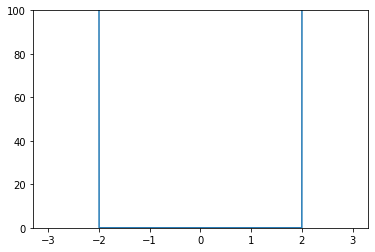

In [75]:
#CONTIENT LA PLAGE DES VALEURS DE X UTILES,LA VALEUR DE LA PREMIERE DERIVEE EN x_m, ET LE POTENTIEL. TRACE LE POTENTIEL.
V=V6 #potentiel utilisé
x_m=-3
x_M=3
dx=10**(-2)
eps=dx*10**(-5)
x_range = np.linspace(x_m,x_M,int((x_M-x_m)/dx))
plt.plot(x_range,V(x_range))
#plt.yscale('log')
plt.ylim(0,100)

RECHERCHE LINEAIRE:


  0%|          | 0/1001 [00:00<?, ?it/s]


 
 AUGMENTATION DE LA PRECISION DES ENERGIES:


  0%|          | 0/5 [00:00<?, ?it/s]

 
 RECHERCHE PAR DICHOTOMIE DE L'ENERGIE 1:


  0%|          | 0/10 [00:00<?, ?it/s]

0.3 ===> 0.2978403963722222
 

 
 RECHERCHE PAR DICHOTOMIE DE L'ENERGIE 2:


  0%|          | 0/10 [00:00<?, ?it/s]

1.19 ===> 1.19135081505
 

 
 RECHERCHE PAR DICHOTOMIE DE L'ENERGIE 3:


  0%|          | 0/10 [00:00<?, ?it/s]

2.68 ===> 2.680498857005556
 

 
 RECHERCHE PAR DICHOTOMIE DE L'ENERGIE 4:


  0%|          | 0/10 [00:00<?, ?it/s]

4.7700000000000005 ===> 4.765230229850001
 

 
 RECHERCHE PAR DICHOTOMIE DE L'ENERGIE 5:


  0%|          | 0/10 [00:00<?, ?it/s]

7.45 ===> 7.445468300827777
 



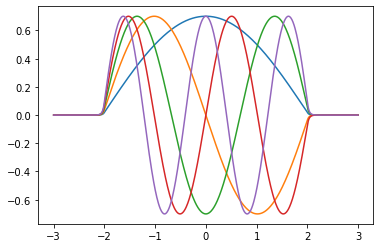

In [76]:
#CONTIENT LA PLAGE D'ENERGIE A TESTER, LE PAS D'ENERGIE POUR LA RECHERCHE LINEAIRE ET LES PARAMETRES DE LA DICHOTOMIE
E_min=0
E_max=10
dE=0.01
sens=-1
Nb_passage=10 #nombre de passage effectués
It_passage=10 #nombre d'iterations effectuées à chaque passage (doit être > 4)
zoom=10 # valeur de l'augmentation de precision entre chaque passage
delta_E=0.1 #étendue de recherche de l'énergie autour de E_ini
recherche(V,E_min,E_max,dE,sens,x_range,Nb_passage,It_passage,zoom,delta_E,eps)